In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mapping from/to integers
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [8]:
# build the dataset
block_size = 3 # context length: how many characters to predict the next one

def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(24)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [9]:
# MLP revisited
n_embd = 10
n_hidden = 200

g =torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator = g)
W1 = torch.randn((block_size * n_embd, n_hidden),   generator = g)
b1 = torch.randn(n_hidden,                          generator = g)
W2 = torch.randn((n_hidden, vocab_size),            generator = g)
b2 = torch.randn(vocab_size,                        generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total no of parameters
for p in parameters:
    p.requires_grad = True

11897


In [16]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] # embed the characters from current batch into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate for matrixmul
    hpreact = embcat @ W1 + b1 # hiddem layer pre activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 2.2401
  10000/ 200000: 1.9637
  20000/ 200000: 2.4676
  30000/ 200000: 2.1048
  40000/ 200000: 2.0350
  50000/ 200000: 2.3060
  60000/ 200000: 2.4205
  70000/ 200000: 2.2067
  80000/ 200000: 2.2321
  90000/ 200000: 2.5298
 100000/ 200000: 2.3731
 110000/ 200000: 2.1192
 120000/ 200000: 2.1125
 130000/ 200000: 1.7833
 140000/ 200000: 2.0415
 150000/ 200000: 2.3825
 160000/ 200000: 2.2458
 170000/ 200000: 1.9013
 180000/ 200000: 1.7006
 190000/ 200000: 2.5029


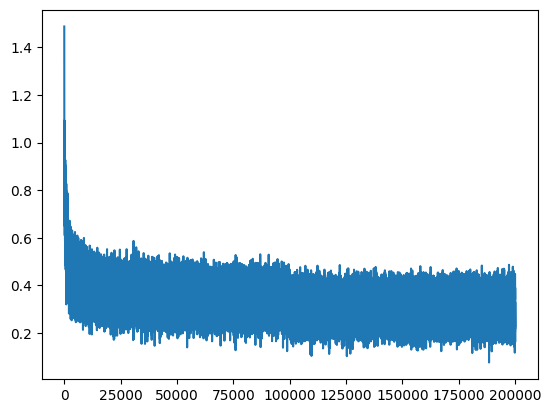

In [11]:
plt.plot(lossi)

In [17]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.010685920715332
val 2.371375799179077
test 2.414461374282837


In [19]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward pass
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0],-1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        #shift the context window
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mona.
kayah.
seel.
nihayla.
remmaniendraeg.
adelyn.
elin.
shi.
jenleigh.
emmanareelyzion.
kalin.
shuberlyn.
mie.
trin.
renlee.
jette.
fin.
zey.
der.
yaralyeha.
